In [2]:
# Import modules
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
from sklearn.model_selection import train_test_split
torch.__version__

'2.2.2'

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [4]:
# Load the dataset and review the first 100 characters
with open("the-verdict.txt", "r",encoding="utf-8") as f:
    raw_text = f.read()
print("Length of text:", len(raw_text))
print(raw_text[:9])

Length of text: 20479
I HAD alw


In [5]:
data = [1,2,3]
tens1 = torch.tensor(data)
print(tens1)

tensor([1, 2, 3])


In [6]:
array = np.array([1,2,3])
print(array)
tens2 = torch.from_numpy(array)
print(tens2)

[1 2 3]
tensor([1, 2, 3])


In [7]:
# Ch 2, p 22 - split text
import re
text = "Hello, world.  This, is a test."
result = re.split(r'([!,.]|\s)', text)
print(result)
result2 = [item for item in result if item.strip()]
print(result2)

['Hello', ',', '', ' ', 'world', '.', '', ' ', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [8]:
# Add more puncuation and  --- to the split (p 23)
text = "Hello, world.  Is this-- a test?"
result = re.split(r'([!,.?:]|--|\s)', text)
print(result)
result2 = [item for item in result if item.strip()]
print(result2)

['Hello', ',', '', ' ', 'world', '.', '', ' ', '', ' ', 'Is', ' ', 'this', '--', '', ' ', 'a', ' ', 'test', '?', '']
['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [9]:
# p24 - Use tokenizer scheme on Wharton text
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))


4690


In [10]:
# Test output of tokenized used on The Verdict  
print(preprocessed[0:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [11]:
# 2.3 - Create a vocabulary (p 25)

# Create list of all uniuqe words and sort
all_words   = sorted(set(preprocessed))
vocab_size  = len(all_words)
print(vocab_size)
print(all_words[-5:])

1130
['yet', 'you', 'younger', 'your', 'yourself']


In [12]:
# Use vocab to create a dictionary
vocab = {token: integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break
    

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [13]:
# p 27 - Make simple tokenizer Class
class SimpleTokenV1:
    
    def __init__(self, vocab):
        self.str_to_int = vocab # stores the vocab dictionary
        self.int_to_str = {integer: string for string, integer in vocab.items()} # reverse dictionary (token IDS to text tokens)

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[token] for token in preprocessed]
        return ids # return the token IDs

    def decoder(self, ids):  # Converts token IDs back to text
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text
    

In [14]:
# Test the tokenizer
tokenizer = SimpleTokenV1(vocab)
text = """"It's the last he painted, you know," 
Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [15]:
# Test the decoder
print(tokenizer.decoder(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [16]:
# Need to account for words not in the vocab (p 30)
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>","<|unk|>"])
vocab = {token: integer for integer, token in enumerate(all_tokens)}
print(len(vocab.items()))

1132


In [17]:
# Confirm that new characters are in the vocab
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [18]:
# p 31 - Adjust tokenizer class to reflect UNK token
class SimpleTokenizerV2:
    
    def __init__(self, vocab):
        self.str_to_int = vocab # stores the vocab dictionary
        self.int_to_str = {integer: string for string, integer in vocab.items()} # reverse dictionary (token IDS to text tokens)

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        # Account for words not in the vocab
        preprocessed = [token if token in self.str_to_int else "<|unk|>" for token in preprocessed]

        ids = [self.str_to_int[token] for token in preprocessed]
        return ids # return the token IDs

    def decoder(self, ids):  # Converts token IDs back to text
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [19]:
# Test the tokenizer adjusted for unknown words
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [20]:
# Get token IDs
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [21]:
# Test the decoder
print(tokenizer.decoder(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [22]:
# 2.5 - p 33 - Byte Pair Encoding

In [23]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.8.0


In [24]:
# Instantiate BPE tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

In [25]:
# Encode text to integers (p 33)
text = (
    "Hello, do you like tea? <|endoftext]> In the sunlit terraces of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 1279, 91, 437, 1659, 5239, 60, 29, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [26]:
# Decode integers back to text
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext]> In the sunlit terraces of someunknownPlace.


In [27]:
# Use BPE on The Verdict (Ch 2.6 - p 35)
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))
print(type(enc_text))

5145
<class 'list'>


In [28]:
# Take sample of encoded text
enc_sample = enc_text[50:]
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x:  {x}")
print(f"y:      {y}")

x:  [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [29]:
#  Test print integers
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "------->", desired)

[290] -------> 4920
[290, 4920] -------> 2241
[290, 4920, 2241] -------> 287
[290, 4920, 2241, 287] -------> 257


In [30]:
# Convert back to text using decoder
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "------->", tokenizer.decode([desired]))

 and ------->  established
 and established ------->  himself
 and established himself ------->  in
 and established himself in ------->  a


In [31]:
# Build dataset Class (Ch. 2.6, p 37-38)

import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"}) # Tokenize the entire text
        token_ids = tokenizer.encode(txt) # Tokenize the entire text
        
        # Uses overlapping chunks of max_length tokens
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk)) 

    # Returns total number of rows in the dataset
    def __len__(self):
        return len(self.input_ids)
    
    # Returns a single row of the dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [32]:
# Dataloader (Ch 2.6 - p38)

def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2") # Instantiate BPE tokenizer
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # Creates dataset
    dataloader = DataLoader(dataset, batch_size=batch_size,
                                              shuffle=shuffle, drop_last=drop_last, # drop_last=True to drop the last incomplete batch
                                                num_workers=num_workers) # num_workers=0 to use single process
    return dataloader

In [33]:
# Test dataloader with batch size of 1 (p 39)

with open("the-verdict.txt", "r",encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [34]:
# Fetch another batch
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [35]:
# Test with larger batch size and stride, so no overlap
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs,targets = next(data_iter)
print("Inputs:\n",inputs)
print("\nTargets:\n",targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [36]:
# 2.7 (p41) - Create token embeddings from token IDs

# Sample input layer
input_ids = torch.tensor([2,3,5,1])

vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


In [37]:
# 2.8 (p 46) - Need to add positional encoding to the token id embeddings
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


In [38]:
# Example (p 46)
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape) 
print(type(inputs)) 
print(type(targets)) 

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [39]:
# Embed token IDs into 256-dimensional vectors (p 46 - 47)
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [40]:
# Absolute embedding position
context_length = max_length
pos_embedding_layer = nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)
print(pos_embeddings)


torch.Size([4, 256])
tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)


In [41]:
# Combine token and positional embeddings
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)
#print(input_embeddings)

torch.Size([8, 4, 256])


In [42]:
# Ch 3 Coding Attention Mechanism (p 50)

In [43]:
# p57 - Simple self-attention mechanism without trainable weights
import torch

# Create a tensor with 3 token embeddings
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
     [0.55, 0.87, 0.66], #  journey (x^2)
     [0.57, 0.85, 0.64],  # starts (x^3)
     [0.22, 0.58, 0.33],  # with (x^4)
     [0.77, 0.25, 0.10],  # one (x^5)
     [0.05, 0.80, 0.55]],  # step (x^6) 
     
)

print(inputs.shape)

torch.Size([6, 3])


In [44]:
# p 58

query = inputs[1]
print(query)
print(query.shape)

att_scores_2 = torch.empty(inputs.shape[0])
print(att_scores_2)
print(att_scores_2.shape)

for i,x_i in enumerate(inputs):
    print(i,x_i)
    att_scores_2[i] = torch.dot(x_i, query)
print(att_scores_2)

tensor([0.5500, 0.8700, 0.6600])
torch.Size([3])
tensor([0., 0., 0., 0., 0., 0.])
torch.Size([6])
0 tensor([0.4300, 0.1500, 0.8900])
1 tensor([0.5500, 0.8700, 0.6600])
2 tensor([0.5700, 0.8500, 0.6400])
3 tensor([0.2200, 0.5800, 0.3300])
4 tensor([0.7700, 0.2500, 0.1000])
5 tensor([0.0500, 0.8000, 0.5500])
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [45]:
# Normalize the attention scores
attn_weights_2_tmp = att_scores_2 / att_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum",attn_weights_2_tmp.sum())   

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum tensor(1.0000)


In [46]:
# Use softmax function to normalize the attention scores (p60)
def softmax_naive(x):
    exp_x = torch.exp(x)
    return exp_x / exp_x.sum(dim=0)

attn_weights_2_naive = softmax_naive(att_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum tensor(1.)


In [47]:
# Better to use PyTorch's softmax function
attn_weights_2 = torch.softmax(att_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum tensor(1.)


In [48]:
# Compute context vectors
query = inputs[1]
print(query)

context_vec_2 = torch.zeros(query.shape)
print("Context_vec_2 shape",context_vec_2.shape)

for i, x_i in enumerate(inputs):
    print(i, x_i)
    print(attn_weights_2[i])
    context_vec_2 += attn_weights_2[i] * x_i
print(context_vec_2)

tensor([0.5500, 0.8700, 0.6600])
Context_vec_2 shape torch.Size([3])
0 tensor([0.4300, 0.1500, 0.8900])
tensor(0.1385)
1 tensor([0.5500, 0.8700, 0.6600])
tensor(0.2379)
2 tensor([0.5700, 0.8500, 0.6400])
tensor(0.2333)
3 tensor([0.2200, 0.5800, 0.3300])
tensor(0.1240)
4 tensor([0.7700, 0.2500, 0.1000])
tensor(0.1082)
5 tensor([0.0500, 0.8000, 0.5500])
tensor(0.1581)
tensor([0.4419, 0.6515, 0.5683])


In [49]:
# Context vectors for all queries

In [50]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x_i,x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [51]:
# Faster way using matrix multiplication
attn_scores = torch.matmul(inputs, inputs.T)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [52]:
# Normalize the attention scores
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [53]:
# Compute context vectors
all_context_vecs = torch.matmul(attn_weights, inputs)
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [54]:
# Alt 2 (3.4 p 64) - Implementing the self atttention with trainable weights

In [55]:
x_2 = inputs[1]
print(x_2)
d_in = x_2.shape[0]
print("d_in",d_in)
d_out = 2

tensor([0.5500, 0.8700, 0.6600])
d_in 3


In [56]:

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)
print("W_query:", W_query)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)
print("W_key",W_key)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)
print("W_value",W_value)

W_query: Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])
W_key Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])
W_value Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [57]:
# Compute Query, Key, and Value vectors
query_2 = torch.matmul(x_2, W_query)
query_2_v2 = x_2 @ W_query
key_2 = torch.matmul(x_2, W_key)
value_2 = torch.matmul(x_2, W_value)

print("Query:", query_2)
print("Query_v2:", query_2_v2)

Query: tensor([0.4306, 1.4551])
Query_v2: tensor([0.4306, 1.4551])


In [58]:
# Compute all keys and values
keys = torch.matmul(inputs, W_key)
print("Keys:", keys)
print("Keys shape:", keys.shape)
values = torch.matmul(inputs, W_value)
print("Values:", values)
print("Values shape:", values.shape)

Keys: tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])
Keys shape: torch.Size([6, 2])
Values: tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])
Values shape: torch.Size([6, 2])


In [59]:
# Calc attention scores - unnormalized
keys_2 = keys[1]
print("keys_2:", keys_2)
attn_scores_2 = query_2.dot(keys_2)
attn_scores_2_v2 = query_2 @ keys_2
attn_scores_2_v3 = torch.matmul(query_2, keys_2)
print("Attention scores:", attn_scores_2)
print("Attention scores_v2:", attn_scores_2_v2)
print("Attention scores_v3:", attn_scores_2_v3)

keys_2: tensor([0.4433, 1.1419])
Attention scores: tensor(1.8524)
Attention scores_v2: tensor(1.8524)
Attention scores_v3: tensor(1.8524)


In [60]:
# All attention scores
att_scores_2 = query_2 @ keys.T
print("Attention scores:", att_scores_2)

Attention scores: tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [61]:
# Normalize the attention scores
d_k = keys.shape[1]
print(d_k)
attn_weights_2 = torch.softmax(att_scores_2 / (d_k ** 0.5), dim=-1)
print("Attention weights:", attn_weights_2)
print("Attention weights shape:", attn_weights_2.shape)

2
Attention weights: tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
Attention weights shape: torch.Size([6])


In [62]:
# Single context vector
context_vec_2 = attn_weights_2 @ values
print("Context vector:", context_vec_2)

Context vector: tensor([0.3061, 0.8210])


In [63]:
# Create Class for self-attention mechanism (p 70)

In [64]:
import torch
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        query = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        attn_scores = query @ keys.T
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / (d_k ** 0.5), dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [65]:
# Test the newly created class
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [66]:
# Make better version using more stable nn.Linear - using diff wt initialization scheme (p 72 - 73)
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out,bias=qkv_bias)

    def forward(self, x):
        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = query @ keys.T
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / (d_k ** 0.5), dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [67]:
# Test it
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [68]:
# 3.5 Hiding future words with Causal Masking (p 74)

In [69]:
# Compute attention weights
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)  
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [70]:
# Create mask using tril so values above diagonal are zero
context_length = attn_scores.shape[0]
print(context_length)
mask_simple = torch.tril(torch.ones(context_length, context_length)) 
print(mask_simple)  

6
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [71]:
# Multiply mask with attention weights
masked_simple = attn_weights * mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [72]:
# Renormalize the masked attention weights
rows_sums = masked_simple.sum(dim=-1,keepdim=True)
masked_simple_norm = masked_simple / rows_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [73]:
# More efficient way to do it - use negative infinity before softmax
mask = torch.triu(torch.ones(context_length, context_length),diagonal=1)
masked =attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)   

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [74]:
# Apply softmax to this more efficient mask
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [75]:
# Masking with dropout (p 78)
# used (1) after calculating attention weights and (2) after applying attention weights to value vectors

In [76]:
# Create a mask with 50% of values set to zero - simple example
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [77]:
# Apply dropout to attention weights - actual
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


In [78]:
#  Create compact casual attention class
# Need to allow for batch inputs

batch = torch.stack((inputs,inputs),dim=0)
print(batch[0])
print(batch.shape)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])
torch.Size([2, 6, 3])


In [79]:
# New class with Causal Masking and Dropout (p 81)
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        print("d_out",d_out)
        print("context_length",context_length)
        print("dropout",dropout)
        self.W_query = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out,bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)  # Added dropout layer

        # Self register buffer used to keep buffer tensors and model params on same device (GPU vs CPU)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))
        #print("mask",self.mask)

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        print("batch:",b)
        print("num_tokens:",num_tokens)
        print("d_in:",d_in)
        query = self.W_query(x)
        keys = self.W_key(x)
        #print("keys shape",keys.shape)
        #print("keys:",keys)
        values = self.W_value(x)

        attn_scores = query @ keys.transpose(1,2)

        #mask = torch.triu(torch.ones(attn_scores.shape[0], attn_scores.shape[1]),diagonal=1)
        attn_scores.masked_fill_ = (self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)
        #print("attn_scores shape",attn_scores.shape)
        
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(masked / (d_k ** 0.5), dim=-1)
        
        attn_weights = self.dropout(attn_weights)
        
        context_vecs = attn_weights @ values
        return context_vecs

In [80]:
# Test case
torch.manual_seed(123)
context_length = batch.shape[1]
print(context_length)
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)
print("first context_vecs:", context_vecs[0])

6
d_out 2
context_length 6
dropout 0.0
batch: 2
num_tokens: 6
d_in: 3
context_vecs.shape: torch.Size([2, 6, 2])
first context_vecs: tensor([[-0.4519,  0.2216],
        [-0.5695,  0.0343],
        [-0.6141, -0.0377],
        [-0.5642, -0.0717],
        [-0.5490, -0.0906],
        [-0.5291, -0.0961]], grad_fn=<SelectBackward0>)


In [81]:
# Create multi-head attention class (p 84) -- output context vectors are concatenated
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)])

    def forward(self, x):
        context_vecs = [head(x) for head in self.heads]
        context_vecs = torch.cat(context_vecs, dim=-1)
        return context_vecs

In [82]:
# Test multi-head attention
torch.manual_seed(123)
context_length = batch.shape[1] # Number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape",context_vecs.shape)
# First dimension of 2 for batches, second of 6 is num of elements, 4 is 2 output contcext vectors for each of the 2 heads

d_out 2
context_length 6
dropout 0.0
d_out 2
context_length 6
dropout 0.0
batch: 2
num_tokens: 6
d_in: 3
batch: 2
num_tokens: 6
d_in: 3
tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5695,  0.0343,  0.5668,  0.2819],
         [-0.6141, -0.0377,  0.6008,  0.3481],
         [-0.5642, -0.0717,  0.5462,  0.3445],
         [-0.5490, -0.0906,  0.5318,  0.3359],
         [-0.5291, -0.0961,  0.5093,  0.3362]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5695,  0.0343,  0.5668,  0.2819],
         [-0.6141, -0.0377,  0.6008,  0.3481],
         [-0.5642, -0.0717,  0.5462,  0.3445],
         [-0.5490, -0.0906,  0.5318,  0.3359],
         [-0.5291, -0.0961,  0.5093,  0.3362]]], grad_fn=<CatBackward0>)
context_vecs.shape torch.Size([2, 6, 4])


In [83]:
# Multi-head attention class (p 86)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # Confirm that d_out is divisible by num_heads
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2)  
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vecs = (attn_weights @ values).transpose(1,2)
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out)
        context_vecs = self.out_proj(context_vecs)
        
        return context_vecs




In [84]:
# Test (p 90)  
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
print("batch_size",batch_size)
print("context_length",context_length)  
print("d_in",d_in)

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape", context_vecs.shape)

batch_size 2
context_length 6
d_in 3
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape torch.Size([2, 6, 2])


In [85]:
# TEST
x = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])
print(x)
print(x.shape)

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])


In [86]:
x_trans = x.transpose(0,1)
print(x_trans)
print(x_trans.shape)

tensor([[1, 4],
        [2, 5],
        [3, 6]])
torch.Size([3, 2])


In [87]:
x_view = x.view(3,2)
print(x_view)

tensor([[1, 2],
        [3, 4],
        [5, 6]])


In [88]:
# Multiply
x_mm = x @ x.T
print(x_mm)

tensor([[14, 32],
        [32, 77]])


In [89]:
# Ch 4 - Coding an LLM Architecture (p 95)

In [90]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Same as BPE vocab size
    "context_length": 1024, # Max num of input tokens
    "emb_dim": 768, # Embedding size for each token
    "n_heads": 12,  # Num of attention heads in each multi-head attention layer
    "n_layers": 12, # Num of transformer blocks
    "drop_rate": 0.1,  # 0.1 means 10% dropped
    "qkv_bias": False    # Whether to add a learnable bias to the query, key, and value projections
} 

In [91]:
# p 96

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"],bias=False)


    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


# p 97
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
    

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

In [92]:
# Create small sample text to run through the model (p 97)

import tiktoken

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [93]:
# Initialize the model and feed it text (p 98)
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print("Logits:", logits)

Output shape: torch.Size([2, 4, 50257])
Logits: tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [94]:
# Test exampple of a NN layer
torch.manual_seed(123)
batch_example = torch.rand(2, 5)
print("batch example",batch_example)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

batch example tensor([[0.2961, 0.5166, 0.2517, 0.6886, 0.0740],
        [0.8665, 0.1366, 0.1025, 0.1841, 0.7264]])
tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [95]:
# Calc mean and variance
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [96]:
# Normalize
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs",out_norm)
mean = out_norm.mean(dim=-1, keepdim=True)
print("Mean:\n", mean)
var = out_norm.var(dim=-1, keepdim=True)
print("Variance:\n", var)

Normalized layer outputs tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[ 0.0000e+00],
        [-9.9341e-09]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [97]:
# Turn off scientific notation for better readability
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [98]:
# Create layer norm class (p 103)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True,unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

In [99]:
# Use newly created layer norm class
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False ,keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


In [100]:
# Create feed forward network with GELU activation (p 105)

class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1+torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * x**3)))

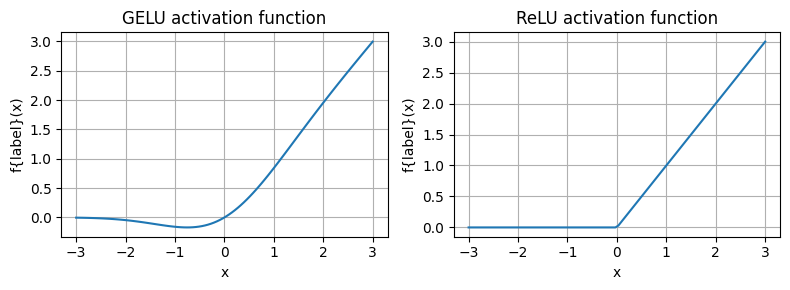

In [103]:
# Plot GELU vs ReLU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]),1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("f{label}(x)")
plt.tight_layout()
plt.show()

In [104]:
# Use GELU in feed forward network (p 107)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"],cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

In [105]:
# Test FFN (p 108)
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [106]:
# Shortcut connection (p 109) aka skip or residual connection (used to mitigate vanishing gradient problem)
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
    
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),
                           nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),
                            nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),
                            nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),
                            nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),
                            nn.GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_out = layer(x)
            if self.use_shortcut and x.shape == layer_out.shape:
                x = x + layer_out
            else:
                x = layer_out
        return x



In [107]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [108]:
# Create function that computes gradients in backwards pass (p 111)
def print_gradients(model, x):

    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")



In [109]:
# Use the function to compute gradients
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020174124801997095
layers.1.0.weight has gradient mean of 0.00012011772923870012
layers.2.0.weight has gradient mean of 0.0007152438047342002
layers.3.0.weight has gradient mean of 0.0013988513965159655
layers.4.0.weight has gradient mean of 0.005049603525549173


In [110]:
# Compare by running with skip connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22186797857284546
layers.1.0.weight has gradient mean of 0.20709273219108582
layers.2.0.weight has gradient mean of 0.3292388319969177
layers.3.0.weight has gradient mean of 0.2667771577835083
layers.4.0.weight has gradient mean of 1.3268064260482788


In [111]:
# Create Transformer block class (p 115)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"], 
            d_out = cfg["emb_dim"], 
            context_length= cfg["context_length"], 
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"], 
            qkv_bias = cfg["qkv_bias"])

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        #x = self.att(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [112]:
# Example (p 116)
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)
print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [113]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Same as BPE vocab size
    "context_length": 256, # Max num of input tokens
    "emb_dim": 768, # Embedding size for each token
    "n_heads": 12,  # Num of attention heads in each multi-head attention layer
    "n_layers": 12, # Num of transformer blocks
    "drop_rate": 0.1,  # 0.1 means 10% dropped
    "qkv_bias": False    # Whether to add a learnable bias to the query, key, and value projections
}

In [114]:
# Combined GPT model implementation (p 119)
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [115]:
# Test the model

import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

print(batch)
out = model(batch)
print("Input batch:\n", batch)
print("Output shape:\n", out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape:
 torch.Size([2, 4, 50257])
tensor([[[    -0.1795,      0.2852,     -0.7613,  ...,     -0.4837,
              -0.4250,     -0.1719],
         [    -0.6258,     -0.3748,     -0.9702,  ...,      0.1917,
              -1.3234,     -0.2764],
         [     0.5174,      0.1387,      0.2489,  ...,      0.3505,
              -0.0775,     -0.0800],
         [    -0.2566,     -0.6969,     -0.9948,  ...,     -0.0447,
               0.0618,      0.1347]],

        [[    -0.2238,      0.1165,     -0.9984,  ...,     -0.1573,
              -0.4480,     -0.0286],
         [    -0.8723,     -0.3939,     -1.1099,  ...,      0.3303,
              -0.0924,     -0.0000],
         [     0.4599,     -0.1427,     -0.1223,  ...,      0.2749,
               0.0583,     -0.0899],
         [    -0.6216,     -0.4485,     -0.4767,  ...,     -0.3652,
  

In [116]:
# Count params

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [117]:
# But the 163 mm figure above double counts the parameters in the output layer. 
# This is called weight tying and is a common technique in LLMs to reduce the number of parameters.
# SIG - reuses weights from embedding layer in output layer

print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [118]:
# Remove output layer param count
total_params_gpt2 = (
    total_params - sum(p.numel()
                       for p in model.out_head.parameters())
)

print(f"Number of trainable params"
      f"considering weight tying: {total_params_gpt2:,}")

Number of trainable paramsconsidering weight tying: 123,822,336


In [119]:
# Calculate total size of model
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 619.58 MB


In [120]:
# Create function to generate text (p 124)

def generate_text_simple(model,idx,max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] # Crops context if too large
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1, :]  # Focus on last time step
        probas = torch.softmax(logits, dim=-1)  # Shape is (batch, vocab_size)
        idx_next = torch.argmax(probas, dim=-1,keepdim=True)  # Shape (batch, 1)
        idx = torch.cat((idx, idx_next),dim=1)  # Appends newest work, idx shape (batch, n_tokens + 1)
    return idx

In [121]:
# Example (p 125)
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape: ",encoded_tensor.shape)


encoded: [15496, 11, 314, 716]
encoded_tensor.shape:  torch.Size([1, 4])


In [122]:
# eval mode disables random components

model.eval()
out = generate_text_simple(
    model=model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 16620, 34991]])
Output length: 10


In [123]:
# Convert IDs back to text using decoder
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Laur inhab DistrinetalkQueue


In [124]:
# Produces gibberish because using random initial weights and no training (yet)

In [125]:
# Ch 5 Pretraining on unlabeled data (p128)

In [126]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Same as BPE vocab size
    "context_length": 256, # Changed from 1024 in earlier model
    "emb_dim": 768, # Embedding size for each token
    "n_heads": 12,  # Num of attention heads in each multi-head attention layer
    "n_layers": 12, # Num of transformer blocks
    "drop_rate": 0.1,  # 0.1 means 10% dropped
    "qkv_bias": False    # Whether to add a learnable bias to the query, key, and value projections
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # Disables dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [127]:
# Create utility functions fpr text to token ID conversions (p 131 - 132)

import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Unsqueeze adds batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)  # Removes batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=  GPT_CONFIG_124M['context_length']

)

print("Output text:\n", token_ids_to_text(token_ids,tokenizer))




Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [128]:
# p 133 examples

inputs = torch.tensor([[16833,3626, 6100],
                       [40,1107,588]])

targets = torch.tensor([[3626,6100,345],
                        [1107,588,11311]])

In [129]:
# Create logits, convert into prob scores
import torch
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)



torch.Size([2, 3, 50257])


In [130]:
# Get token IDs using argmax
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print("Token IDs:\n",token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [131]:
# Convert token ids back to text
print(f"Targets batch 1:{token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch 1:"
      f"{token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1: effort moves you
Outputs batch 1: Armed heNetflix


In [132]:
# Get initial softmax prob scores corresp to target tokens
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 1:",target_probas_1)

text_idx=1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 2:",target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


In [133]:
# Need to convert target probas to log
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [134]:
# Get avg of log probas
avg_log_probas = torch.mean(log_probas)
print((avg_log_probas))

tensor(-10.7940)


In [135]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [136]:
# Avg neg log loss is similar to cross-entropy and used interchangeably

# CHeck shape of logitsand targets

print("Logits shape: ",logits.shape)
print("Targets shape:", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [137]:
# For cross entropy need to flatten tensors by combining over batch dimension

logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten(0,1)
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:,", targets_flat.shape)


Flattened logits: torch.Size([6, 50257])
Flattened targets:, torch.Size([6])


In [138]:
# use cross entropy function
# In one step this applies softmax, selects prob score corresp to target id, and compute neg avg log prob

loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7940)


In [139]:
# Perplexity (p 139) -  how well does model's prob dist match actual prob dist
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


In [140]:
# Reuse text from The Verdict (p 141)

file_path = "the-verdict.txt"
with open(file_path, "r", encoding='utf-8') as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [141]:
print(text_data[:50])

I HAD always thought Jack Gisburn rather a cheap g


In [142]:
# Split data into training and validation sets
train_ratio = 0.90
split_index = int(train_ratio * len(text_data))
train_data = text_data[:split_index]
val_data = text_data[split_index:]

In [143]:
# Create dataloaders (p 143)

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


In [144]:
# Confirm dataloaders created correctly

print("Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [145]:
# Utility function to calculate cross entropy loss for a given batch (p 144)

def calc_loss_batch(input_batch,target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()  
    )
    return loss

In [146]:
# Create function to compute loss for all batches in dataloader rather than just one
# p 144

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch,target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [147]:
# Apply this function to training and validation loaders (p 145)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
print("Training loss:", train_loss)
print("Validation loss:",val_loss)

cpu


Training loss: 10.987583372328016
Validation loss: 10.98110580444336


In [148]:
# Func to show training and validation set losses (p 148)

#def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#    model.eval()
#    with torch.no_grad():
#       train_loss = calc_loss_loader(
#            train_loader, model, device, num_batches=eval_iter
#        )
#        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter
#                                    )
#        model.train()
#        return train_loss, val_loss

In [149]:
# Function to track model improvement

#def generate_and_print_sample(model, tokenizer, device, start_context):
#    model.eval()
#    context_size = model.pos_emb.weight.shape[0]
#    encoded = text_to_token_ids(start_context,tokenizer).to(device)
#    with torch.no_grad():
#        token_ids = generate_text_simple(
#            model=model, idx=encoded,
#            max_new_tokens=50, context_size=context_size
#        )
#    decoded_text = token_ids_to_text(token_ids,tokenizer)
#   print(decoded_text.replace("\n", " "))
#    model.train()

In [150]:
# Training an LLM (5.2) - p 146

def train_model_simple(model,train_loader,val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch,target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}):  "
                    f"Train loss {train_loss:.3f},"
                    f"Val loss {val_loss:.3f}"
                    )
        
        generate_and_print_sample(model,tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter
                                    )
        model.train()
        return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [151]:
# Test  - run GPTModel instance for 10 epochs (p 149)

import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
#print(model)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you",tokenizer=tokenizer
)


Ep 1 (Step 000000):  Train loss 9.781,Val loss 9.933
Ep 1 (Step 000005):  Train loss 8.111,Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010):  Train loss 6.661,Val loss 7.048
Ep 2 (Step 000015):  Train loss 5.961,Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,


In [152]:
# Create charts to show training and validation losses (p 150)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_losses,label="Training loss")
    ax1.plot(epochs_seen,val_losses,linestyle="-.",label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen,train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()



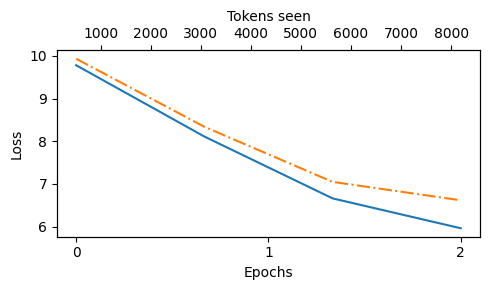

In [153]:
# plot sample graph

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor,tokens_seen, train_losses, val_losses)

In [154]:
# Decoding strategies to control randomness (p 151)

model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [155]:
# Put GPT model into generate_text_simple model

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']

)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))


Output text:
 Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and,


In [156]:
# Temperature scaling
# previously used argmax to select highest prob token (greedy decoding), now use probabilistic sampling

vocab = {
    "closer":0,
    "every":1,
    "effort":2,
    "forward":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8,
}
inverse_vocab = {v:k for k,v in vocab.items()}


In [157]:
print(inverse_vocab)

{0: 'closer', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [158]:
# p 153 - sample logits based on "Every effort moves you"

next_token_logits = torch.tensor(
    [4.51,0.89,-1.90,6.75,1.63,-1.62,-1.89,6.28,1.79]
)

In [159]:
# Convert to probs
probas = torch.softmax(next_token_logits,dim=0)
print("Probas:\n",probas)
#  Get ID for next token
next_token_id = torch.argmax(probas).item()
print("Next token id:\n",next_token_id)
print(inverse_vocab[next_token_id])

Probas:
 tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
Next token id:
 3
forward


In [160]:
# Now make this probabilistic rather than just using argmax
torch.manual_seed(123)
next_token_id = torch.multinomial(probas,num_samples=1).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

3
forward


In [161]:
# Run 1000 samples to see how many times it chooses each possible word
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas,num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [162]:
# Add temperature to dist = div logits by some num > 0. Temp >1 = more uniform distrib

def softmax_with_temperature(logits,temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits,dim=0)

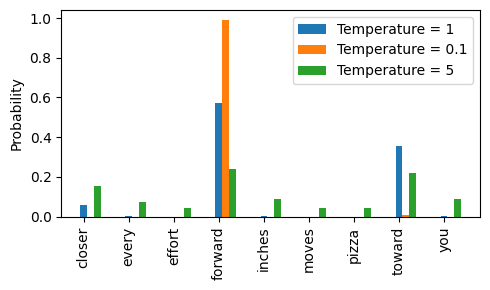

In [163]:
temperatures = [1,0.1,5]
scaled_probas = [softmax_with_temperature(next_token_logits,T)
                 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax  = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x+i * bar_width, scaled_probas[i],
                   bar_width,label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [164]:
# Top k-sampling - restrict sampling to k most likely tokens and mask the rest with -inf

top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions", top_pos)



Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions tensor([3, 7, 0])


In [165]:
# Set values below threshold to -inf
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [166]:
# p 157 - now convert top-k to new probs
topk_probas = torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [167]:
# Combine temp sampling and topk
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0,top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx,idx_next),dim=-1)
    return idx

In [168]:
# Test new function
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx = text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4

)

print("Output text:\n",token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, I. I it a,." me " my a " had


In [169]:
# Ch 5.4 - Loading & Saving Model Weights (p 159)

torch.save({
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
},
"model_and_optimizer.pth"
)

In [170]:
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [171]:
# Loading Pretrained Weights from OpenAI (p161)

In [172]:
#import tensorflow as tf
#print(tf.config.list_physical_devices())

In [173]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")#

print(f"Using {device} device.")


Using mps device.


In [174]:
import torch
device = torch.device("cpu")
print(f"Using {device} device.")

Using cpu device.


In [175]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [176]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


In [177]:
from tqdm import tqdm

In [178]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url,filename)

('gpt_download.py', <http.client.HTTPMessage at 0x3473f9cd0>)

In [179]:
import time
start_time = time.time()
from gpt_download import download_and_load_gpt2
end_time = time.time()

print(f"Import took {end_time - start_time:.2f} seconds")


Import took 0.00 seconds


In [180]:
# Load GPT wts from get_download.py file

settings, params = download_and_load_gpt2(
    model_size="124M", models_dir='gpt2'
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 20.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.41MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 72.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:26<00:00, 5.78MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.94MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 2.09MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.05MiB/s]


In [190]:
# Inspects settings and params

print("Settings:", settings)
print("Parameter Dictionary Keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter Dictionary Keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [182]:
# Need to transfer setting and params info into our GPT model
# Create a dict

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [191]:
# Example of loading smallest model
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [192]:
# Update config length
NEW_CONFIG.update({"context_length":1024})

In [194]:
# Update bias param
NEW_CONFIG.update({"qkv_bias":True})

In [195]:
# Use updated config to create new model (p 164)
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [187]:
# Override random weights with weights loaded into params dict (p165)

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: Left {left.shape}, "
                        "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [199]:
# Create function to load weights from params dict into GPT model (Ch 5.5, p 165)

import numpy as np

def load_weights_into_gpt(gpt,params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight,params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight,params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]['attn']['c_attn'])['w'],3,axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]['attn']['c_attn'])['b'],3,axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]['attn']['c_proj']['w'].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]['attn']['c_proj']['b'])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]['mlp']['c_fc']['w'].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]['mlp']['c_fc']['b'])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]['mlp']['c_proj']['w'].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]['mlp']['c_proj']['b'])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]['ln_1']['g'])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]['ln_1']['b'])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]['ln_2']['g'])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]['ln_2']['b']
        )
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
    gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])



In [200]:
# Test function above and load OpenAI model wts into GPT model
load_weights_into_gpt(gpt,params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [202]:
# Generate text using generate function

torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you",tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=50,
    temperature=1.5
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))


Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




In [203]:
# Ch 6 Fine Tuning For Classification (p 169)

In [204]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [205]:
# Load data into pandas df (p 173)
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [206]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [207]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [208]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})   

In [209]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [210]:
# Create function to randomly split data into train and test sets (p 175)
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [211]:
# When batching need to either truncate longer messages or pad shorter ones. 
# Padding is more common.  Padding is done by adding special token to end of message

# Check token number for endoftext
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


In [212]:
# Create PyTorch Dataset class (p 177)

import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # Note: A more pythonic version to implement this method
        # is the following, which is also used in the next chapter:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)


In [213]:
# Note:  Text sequences all need to ne the same length

train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)

print(train_dataset.max_length)


120


In [216]:
# Create val and test datasets (p 178) - max_length same as training dataset

val_dataset = SpamDataset(
    csv_file="validation.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [217]:
# Create Dataloader for training dataset (p 180)

from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [218]:

# Confirm dataloaders created correctly (p 180)

print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [219]:
# Check how many batches in each set
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [220]:
# 6.4 p 181 - Initialize model with pretrained weights

# Set config
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)


In [221]:
# Reuse GPT class then download weights (p 182)

from gpt_download import download_and_load_gpt2
#from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:06<00:00, 7.48MiB/s] 


File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [222]:
#  Test that imported model generates coherent text (p 182)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [223]:
# Try to prompt model and see if it can classify as spam or not

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [224]:
# Review model architecture (p 185)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [225]:
# Freeze wts to prep for classification tuning (p 186)
for param in model.parameters():
    param.requires_grad = False

In [227]:
# Replace outputlayer (originally 768 mapping to vocab size of 50257) with new layer (0,1)
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG['emb_dim'],
    out_features=num_classes,
)
# requires_grad = True by default, which makes only this last layer trainable

In [228]:
# Also need to make final norm layer and transformer blocks trainable

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [229]:
# Can still use the model as before
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [230]:
# Show that there are only 2 output dimensions now instead of the 50257 previously
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [231]:
# Get info about last token (p 188)

print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [232]:
# Convert logits to probabilities (p 192) using softmax
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [233]:
# Same things but without softmax
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [234]:
# Function to calculate accuracy (p 192)

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [235]:
# Calc accuracy (p 193)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Running on mps device.
Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [236]:
# Need to fine tune.  Cant differentiate so min cross entropy loss (p 194)

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


In [237]:
# Calc loss for all batches (p194)
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [238]:
# Calc loss for training and validation and test sets (p 194)
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [239]:
# 6.7 - Fine Tuning (p 195) on supervised data to lower cross entropy loss and increase accuracy


In [240]:
# Fine tune to classify spam or not spam (p 196)

# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [241]:
# Eval model (p 197)

# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [257]:
# Run training loop (p 197)

import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.402, Val loss 0.420
Ep 1 (Step 000050): Train loss 0.374, Val loss 0.418
Ep 1 (Step 000100): Train loss 0.363, Val loss 0.433
Training accuracy: 87.50% | Validation accuracy: 90.00%
Ep 2 (Step 000150): Train loss 0.466, Val loss 0.404
Ep 2 (Step 000200): Train loss 0.424, Val loss 0.403
Ep 2 (Step 000250): Train loss 0.436, Val loss 0.395
Training accuracy: 82.50% | Validation accuracy: 82.50%
Ep 3 (Step 000300): Train loss 0.391, Val loss 0.389
Ep 3 (Step 000350): Train loss 0.383, Val loss 0.388
Training accuracy: 85.00% | Validation accuracy: 82.50%
Ep 4 (Step 000400): Train loss 0.280, Val loss 0.405
Ep 4 (Step 000450): Train loss 0.430, Val loss 0.381
Ep 4 (Step 000500): Train loss 0.397, Val loss 0.376
Training accuracy: 90.00% | Validation accuracy: 82.50%
Ep 5 (Step 000550): Train loss 0.385, Val loss 0.385
Ep 5 (Step 000600): Train loss 0.455, Val loss 0.367
Training accuracy: 85.00% | Validation accuracy: 90.00%
Training completed in 1.39 minu

In [243]:
# Plot losses

import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

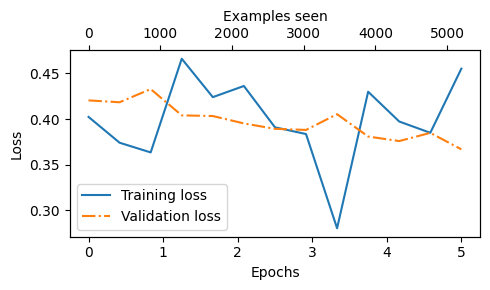

In [258]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

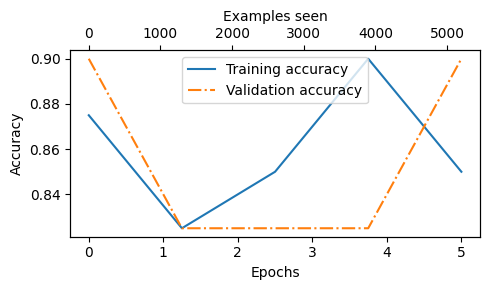

In [260]:
# Plot accuracy

epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [259]:
# Run over training, val and test sets
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 85.58%
Validation accuracy: 88.59%
Test accuracy: 86.33%


In [247]:
# 6.8 Using the LLM as a spam classifier (p 201)


In [248]:
# Use model to classify spam or not spam

def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [249]:
# Test case
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [250]:
# Test case 2

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))


not spam


In [251]:
# Save for reuse (p202)
#torch.save(model.state_dict(), "review_classifier.pth")

In [252]:
# Code for reloading model in a new session (if needed)
#model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
#model.load_state_dict(model_state_dict)

In [261]:
# Ch 7 - Fine Tuning To Follow Instructions (p 204)

In [262]:
# Load 1,100 instruction-response pairs (p 207)

import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [263]:
# Print out a sample entry
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [264]:
# Another example without an input
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [265]:
# Split data into train and test sets (p 210)
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [266]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [268]:
# Create Dataset (p 213)

import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [269]:
# Confirm padding token

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [271]:
# Create custom function (p 215) to pad to same length within each batch (not the whole dataset)

def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor



In [273]:
# Confirm that the function above works

inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [278]:
# Modify custom collate to generate target token IDs from input token IDs (p 217)

In [275]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [276]:
# Test it out

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [279]:
# Need to modify custom collate so only one token has unknown token (50256) and the rest have -100 (p 220)

def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [280]:
# Another test to confirm function working

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])
